鈴木讓「統計的機械学習の数理 with Python 100問」(共立出版)

# 第８章 サポートベクトルマシン

## 8.1 最適な境界

## 8.2 最適化の理論

## 8.3 サポートベクトルマシンの解

In [1]:
! pip install japanize_matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn #正規乱数

In [3]:
# Anacondaの場合は下記( import japanize_matplotlib はコメントアウト)
import matplotlib
from matplotlib import font_manager
matplotlib.rc("font", family="BIZ UDGothic")

In [4]:
import cvxopt
from cvxopt import matrix

In [5]:
# データの生成
a = randn(1)
b = randn(1)
n = 100
X = randn(n, 2)
y = np.sign(a * X[:, 0] + b * X[:, 1] + 0.1 * randn(n))
y = y.reshape(-1, 1)  # 形を明示して渡す必要がある

In [6]:
def svm_1(X, y, C):
    eps = 0.0001
    n = X.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # y[i, 0] * y[j, 0] を使用して、スカラーとしての乗算を保証
            P[i, j] = np.dot(X[i, :], X[j, :]) * y[i, 0] * y[j, 0]
    # パッケージにあるmatrix関数を使って指定する
    P = matrix(P + np.eye(n) * eps)
    q = matrix(-1.0 * np.ones(n))
    G = matrix(np.vstack([np.eye(n), -np.eye(n)]))
    h = matrix(np.hstack([C * np.ones(n), np.zeros(n)]))
    A = matrix(y.reshape(1, -1), tc='d')  # tc='d' でデータ型を指定
    b = matrix(0.0)
    res = cvxopt.solvers.qp(P, q, G, h, A, b)  # ソルバーの実行
    alpha = np.array(res['x'])  # xが本文中のalphaに対応
    beta = ((alpha * y).T @ X).reshape(-1, 1)
    index = (eps < alpha[:, 0]) & (alpha[:, 0] < C - eps)
    beta_0 = np.mean(y[index] - X[index, :] @ beta)
    return {'beta': beta, 'beta_0': beta_0}

     pcost       dcost       gap    pres   dres
 0: -1.4484e+02 -8.6521e+03  2e+04  1e+00  8e-15
 1:  3.6425e+00 -3.0222e+03  5e+03  1e-01  1e-14
 2:  7.3748e+01 -3.8809e+02  6e+02  1e-02  3e-14
 3:  6.2601e+00 -9.0327e+01  1e+02  1e-03  1e-14
 4: -9.4015e+00 -7.6717e+01  7e+01  9e-04  6e-15
 5: -2.1741e+01 -5.6539e+01  3e+01  3e-16  3e-15
 6: -2.8571e+01 -4.8647e+01  2e+01  4e-15  4e-15
 7: -3.2357e+01 -4.0856e+01  8e+00  2e-16  4e-15
 8: -3.5520e+01 -3.6886e+01  1e+00  2e-15  4e-15
 9: -3.6103e+01 -3.6125e+01  2e-02  1e-14  5e-15
10: -3.6114e+01 -3.6115e+01  2e-04  5e-15  5e-15
11: -3.6115e+01 -3.6115e+01  2e-06  5e-15  5e-15
Optimal solution found.


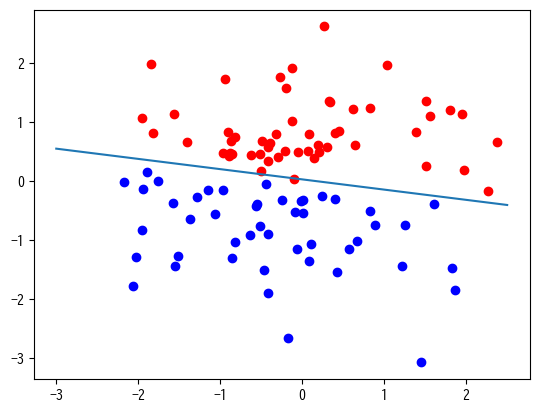

In [7]:
# 結果のプロット
for i in range(n):
    color = "red" if y[i] == 1 else "blue"
    plt.scatter(X[i, 0], X[i, 1], c=color)

# SVMモデルの実行
res = svm_1(X, y, C=10)

def f(x):
    return -res['beta_0'] / res['beta'][1] - x * res['beta'][0] / res['beta'][1]

x_seq = np.arange(-3, 3, 0.5)
plt.plot(x_seq, f(x_seq))
plt.show()

## 8.4 カーネルを用いたサポートベクトルマシンの拡張

In [8]:
def K_linear(x, y):
    return x.T @ y

def K_poly(x, y):
    return (1 + x.T @ y) ** 2

In [9]:
def svm_2(X, y, C, K):
    eps = 0.0001
    n = X.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            P[i, j] = K(X[i, :], X[j, :]) * y[i] * y[j]
    P = matrix(P + np.eye(n) * eps)
    q = matrix(-np.ones(n))
    G = matrix(np.vstack([-np.eye(n), np.eye(n)]))
    h = matrix(np.hstack([np.zeros(n), np.ones(n) * C]))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.array(sol['x'])
    beta = ((alpha*y).T@X).reshape(2,1)
    index = (eps < alpha[:, 0]) & (alpha[:, 0] < C - eps)
    beta_0 = np.mean(y[index] - X[index, :]@beta)
    return {'alpha': alpha, 'beta': beta, 'beta_0': beta_0}

In [10]:
# 実行
a = 3
b = -1
n = 200
X = randn(n, 2)
y = np.sign(a * X[:, 0] + b * X[:, 1] ** 2 + 0.3 * randn(n))
y = y.reshape(-1, 1)

In [11]:
def plot_kernel(K, line):  # 引数lineで線の種類を指定する
    res = svm_2(X, y, 1, K)
    alpha = res['alpha'][:, 0]
    beta_0 = res['beta_0']

    def f(u, v):
        S = beta_0
        for i in range(X.shape[0]):
            S += alpha[i] * y[i] * K(X[i, :], [u, v])
        return S[0]

    uu = np.arange(-2, 2, 0.1)
    vv = np.arange(-2, 2, 0.1)
    ww = []
    for v in vv:
        w = []
        for u in uu:
            w.append(f(u, v))
        ww.append(w)
    plt.contour(uu, vv, ww, levels=0, linestyles=line)

     pcost       dcost       gap    pres   dres
 0: -6.0648e+01 -5.9776e+02  4e+03  4e+00  1e-14
 1: -3.6734e+01 -4.1320e+02  8e+02  6e-01  8e-15
 2: -1.9918e+01 -1.6373e+02  2e+02  1e-01  5e-15
 3: -1.3508e+01 -4.0666e+01  4e+01  2e-02  4e-15
 4: -1.7032e+01 -2.4571e+01  1e+01  4e-03  4e-15
 5: -1.8422e+01 -2.1270e+01  3e+00  1e-03  3e-15
 6: -1.9153e+01 -1.9643e+01  5e-01  9e-05  2e-15
 7: -1.9306e+01 -1.9423e+01  1e-01  2e-05  3e-15
 8: -1.9342e+01 -1.9375e+01  3e-02  5e-06  2e-15
 9: -1.9355e+01 -1.9357e+01  2e-03  4e-08  3e-15
10: -1.9356e+01 -1.9356e+01  2e-04  5e-09  3e-15
11: -1.9356e+01 -1.9356e+01  3e-06  5e-11  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.9025e+01 -5.7736e+02  3e+03  3e+00  4e-15
 1: -5.6829e+01 -4.0179e+02  7e+02  5e-01  2e-15
 2: -4.2879e+01 -1.2849e+02  1e+02  5e-02  1e-14
 3: -5.0105e+01 -6.9122e+01  2e+01  9e-03  3e-15
 4: -5.4586e+01 -6.1582e+01  8e+00  2e-03  2e-15
 5: -5.6268e+01 -5.9075e+01  3e+00  8e-04  1e-1

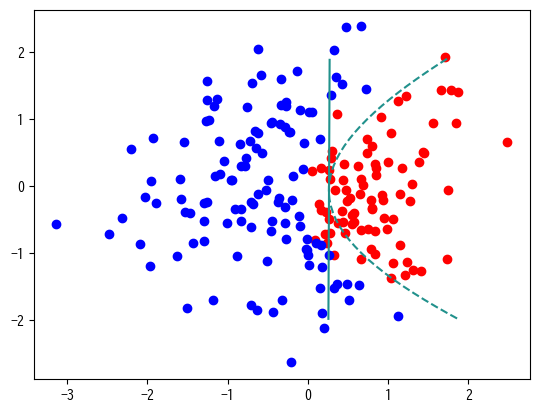

In [12]:
# データのプロット
for i in range(n):
    if y[i] == 1:
        plt.scatter(X[i, 0], X[i, 1], c="red")
    else:
        plt.scatter(X[i, 0], X[i, 1], c="blue")

# カーネル関数によるプロット
plot_kernel(K_poly, line="dashed")
plot_kernel(K_linear, line="solid")

In [13]:
import sklearn
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris

In [14]:
# データの準備
x = np.random.randn(200, 2)
x[0:100, :] = x[0:100, :] + 2
x[100:150, :] = x[100:150, :] - 2
y = np.concatenate(([1 for i in range(150)], [2 for i in range(50)]))

train = np.random.choice(200, 100, replace=False)
test = list(set(range(200)) - set(train))

# SVMモデルの学習
res_svm = svm.SVC(kernel="rbf", gamma=1, C=100)  # チューニングなしのSVM
res_svm.fit(x[train, :], y[train])  # 実行

SVC(C=100, gamma=1)

In [15]:
# テストデータの予測
predictions = res_svm.predict(x[test, :])  # テストデータの予測結果

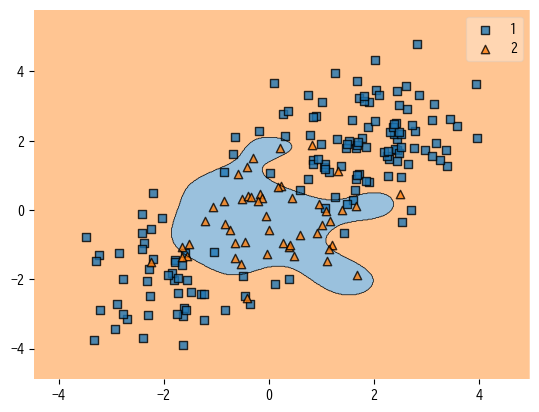

In [16]:
# 決定境界のプロット
plot_decision_regions(x, y, clf=res_svm)
plt.show()

In [17]:
# ハイパーパラメータチューニング
grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.5, 1, 2, 3, 4]}
tune = GridSearchCV(svm.SVC(), grid, cv=10)
tune.fit(x[train, :], y[train])
print(tune.best_params_)  # 最適なパラメータ

{'C': 1, 'gamma': 0.5}


In [18]:
# Irisデータセットに適用
iris = load_iris()
x = iris.data
y = iris.target
train = np.random.choice(150, 120, replace=False)
test = np.ones(150, dtype=bool)
test[train] = False

iris_svm = svm.SVC(kernel="rbf", gamma=1, C=10)
iris_svm.fit(x[train, :], y[train])

SVC(C=10, gamma=1)

In [19]:
# table_count関数の定義
def table_count(m, u, v):
    n = u.shape[0]
    count = np.zeros((m, m))
    for i in range(n):
        count[int(u[i]), int(v[i])] += 1
    return count

In [20]:
y_pre = iris_svm.predict(x[test, :])
print(table_count(3, y[test], y_pre))

[[ 8.  0.  0.]
 [ 0. 11.  2.]
 [ 0.  0.  9.]]
